In [1]:
import os
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tidalUtl.InterfaceSQL as isq
import tidalUtl.PrpUtl as prp
import tidalUtl.EdaUtl as eda
import tidalUtl.VslUtl as vsl
import tidalUtl.ImgUtl as img

# loading some basic packages for testing
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import fetch_openml
#import xgboost as xgb

from tqdm.notebook import tqdm
from skimage import exposure, io
import cv2
from glob import glob
import pickle

import random
from random import randint

import cv2

In [2]:
# config
INPUT = "/home/tidal/ML_Data/BMS_MolTrans/bms-molecular-translation"
OUTPUT = "/home/tidal/ML_Data/BMS_MolTrans/output"

# LABEL

In [3]:
df_train_labels = pd.read_csv(INPUT + "/train_labels.csv")
df_train_labels

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...
...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...


In [4]:
eda.chkDfIsNull(df_train_labels)

There is not NULL.


In [5]:
eda.chkUnique(df_train_labels, "image_id")

image_id is unique.


In [6]:
eda.chkUnique(df_train_labels, "InChI")

InChI is unique.


In [7]:
df_train_labels["InChI"][1000]

'InChI=1S/C19H20FNO4S/c1-12-3-6-15(7-4-12)26(24,25)21-10-9-17(19(22)23)18(21)16-8-5-14(20)11-13(16)2/h3-8,11,17-18H,9-10H2,1-2H3,(H,22,23)/t17-,18+/m0/s1'

・レイヤーによって'/'で区切られる<font color="Red">（’/’の数を数えておくか...）</font><br>
・1S -> standardな書き方という意味らしい。'1'と'1S'しかないらしい<font color="Red">（比を調べておくこと）</font><br>
　また、1Sの場合は一部レイヤーが省略される（'/'が2つ減る）<br>
・元素の種類（CとかHとか）と数<br>
・メインレイヤー1：接頭文字:”c”として原子のつながりを記述する（炭素ではない）<br>
・メインレイヤー2：接頭文字:”h”として水素のつながりを記述する（炭素ではない）<br>
・サブレイヤー:電化、立体化学、同位体などを表すレイヤー(種類によって'/'でつなげていく)<br>
<font color="Red">データの並びが単純なものから複雑なものへと並んでる気がする（'/'が少ないか大きいか）</font><br>
<font color="Red">⇨区切りの多さでfold分けできそう</font><br>
例）<br>
InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3<br>
InChI=1S/C19H20FNO4S/c1-12-3-6-15(7-4-12)26(24,25)21-10-9-17(19(22)23)18(21)16-8-5-14(20)11-13(16)2/h3-8,11,17-18H,9-10H2,1-2H3,(H,22,23)/t17-,18+/m0/s1<br>
[参考(wikipedia)](https://ja.wikipedia.org/wiki/InChI)

In [8]:
df_train_labels["InChI"][1000].split("/")

['InChI=1S',
 'C19H20FNO4S',
 'c1-12-3-6-15(7-4-12)26(24,25)21-10-9-17(19(22)23)18(21)16-8-5-14(20)11-13(16)2',
 'h3-8,11,17-18H,9-10H2,1-2H3,(H,22,23)',
 't17-,18+',
 'm0',
 's1']

In [9]:
INCHIs=df_train_labels["InChI"].values.tolist()

In [10]:
#レイヤー数の計算
INCHIsList=[]
for i, inchi in tqdm(enumerate(INCHIs)):
    #df_train_labels.loc[i, "layerNum"] = inchi.count("/")+1
    INCHIsList.append(inchi.count("/")+1)
    
layerNum_df = pd.DataFrame(INCHIsList, columns=["layerNum"])
df_train_labels = pd.concat([df_train_labels, layerNum_df], axis=1)

In [11]:
df_train_labels

,image_id,InChI,layerNum
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,4
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,7
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,4
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,4
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,4
...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,4
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,4
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,4
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,4


In [12]:
layerNum_df.value_counts().sort_index()

layerNum
3               307
4           1893702
5            133623
6               398
7            371839
8             24162
9               127
10               27
11                1
dtype: int64

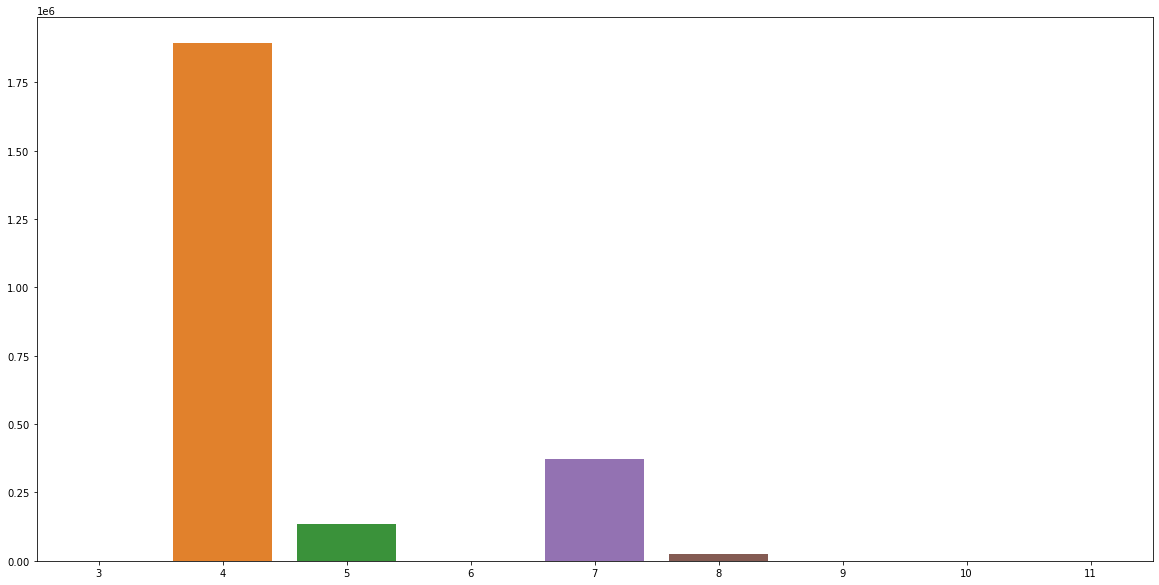

In [13]:
x = []
for i in range(len(layerNum_df.value_counts().index.tolist())):
    x.append(layerNum_df.value_counts().index.tolist()[i][0])
fig = plt.figure(figsize=(20,10))
sns.barplot(x = x, y = layerNum_df.value_counts().values)
plt.show()

・基本的にはレイヤーは4つ。バージョン/化学式/原子のつながり/水素原子の情報のみ。<br>
　バージョンはだいたい固定のはずなので予測するのは3つの情報<br>
・全体の5分の1が上記情報に合わせて立体情報などが入っていると思われる。(5個と7個)<br>
★**foldではこの個数が均等になるように分けること**

In [14]:
#バージョン(1S or 1)の可視化
INCHIs=df_train_labels["InChI"].values.tolist()
num_1 = 0
num_1s = 0
for i in range(len(INCHIs)):
    ver = INCHIs[i][6:8]
    if ver == "1S":
        num_1s += 1
    elif ver == "1/":
        num_1 += 1
    else:
        print(ver)

In [15]:
print(f"num_1:{num_1}")
print(f"num_1s:{num_1s}")

num_1:0
num_1s:2424186


バージョンは全て1S。<br>
★**submit時は決め打ちで最初を'InChI=1S/'にしておけば良い**

# IMAGE

In [16]:
def convert_image_id_2_path(image_id: str) -> str:
    return INPUT + "/train/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )


In [17]:
def visualize_train_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(convert_image_id_2_path(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
#         print(f"{ind}: {label}")
        plt.title(f"{label[:30]}...", fontsize=10)
        plt.axis("off")
    
    plt.show()
    
def visualize_train_image(image_id, label):
    plt.figure(figsize=(10, 8))
    
    image = cv2.imread(convert_image_id_2_path(image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(f"{label}", fontsize=14)
    plt.axis("off")
    
    plt.show()

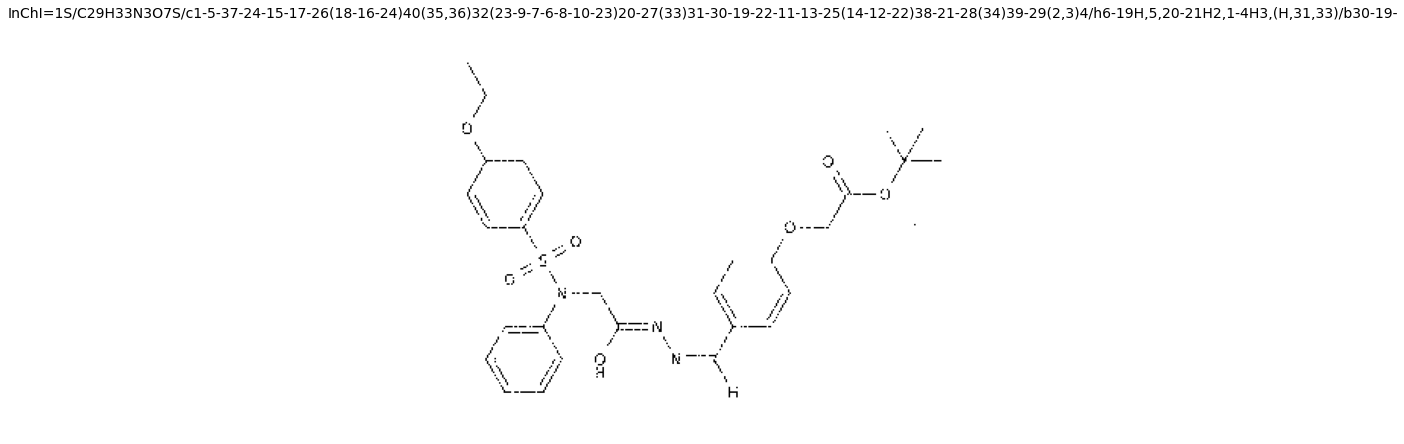

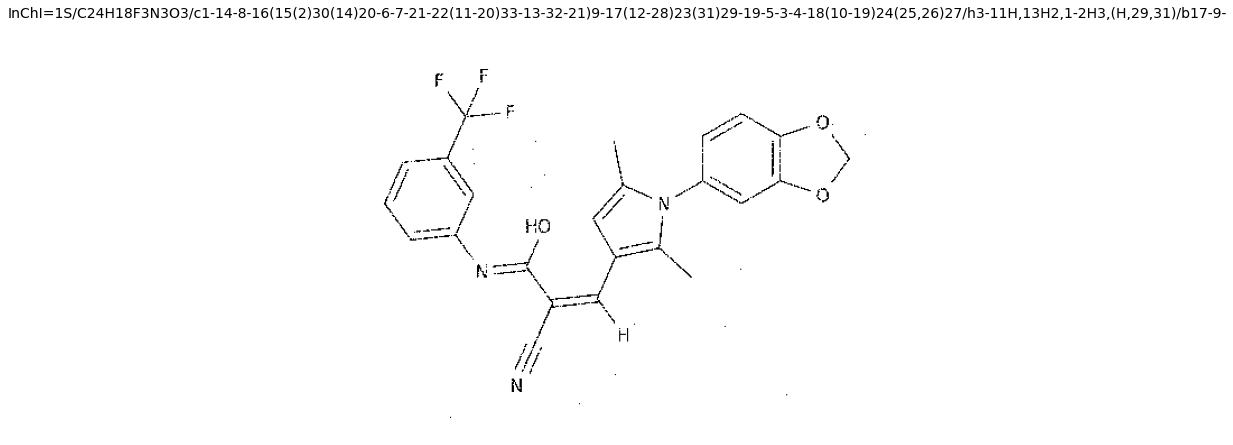

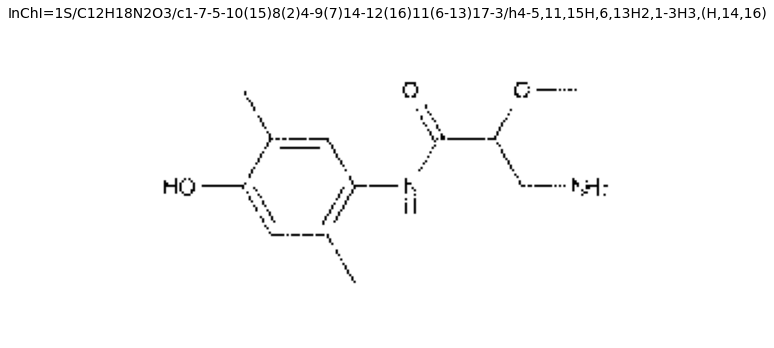

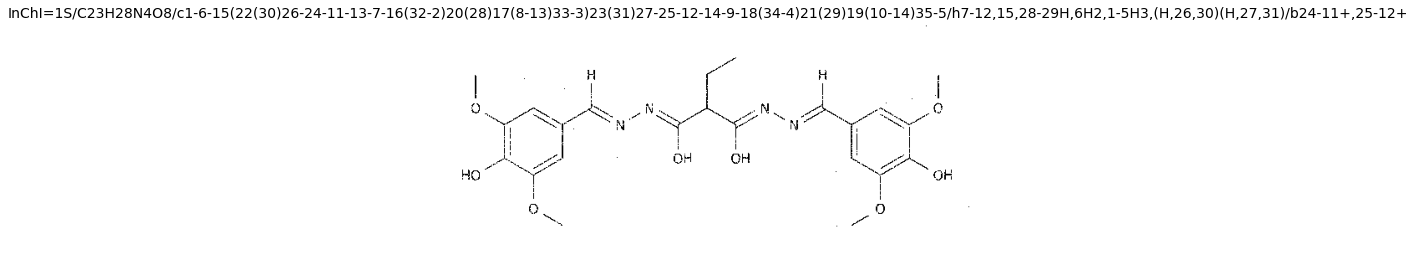

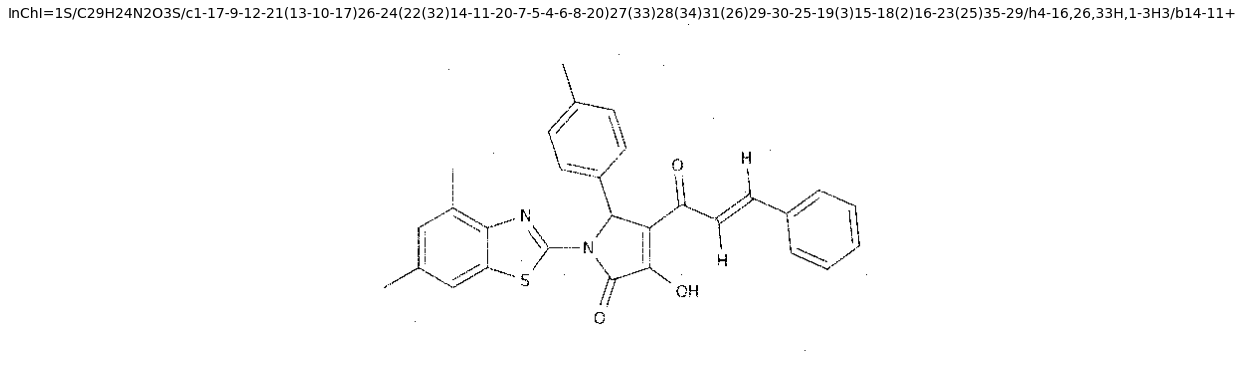

In [18]:
sample_row = df_train_labels.sample(5).reset_index(drop=True)
for i in range(5):
    visualize_train_image(
        sample_row["image_id"][i], sample_row["InChI"][i]
    )

# Preprocessing

In [19]:
# ====================================================
# Library
# ====================================================
import os
import re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import torch

# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT + "/train_labels.csv")
print(f'train.shape: {train.shape}')

# ====================================================
# Preprocess functions
# ====================================================
def split_form(form):
    string = ''
    for i in re.findall(r"[A-Z][^A-Z]*", form):
        elem = re.match(r"\D+", i).group()
        num = i.replace(elem, "")
        if num == "":
            string += f"{elem} "
        else:
            string += f"{elem} {str(num)} "
    return string.rstrip(' ')

def split_form2(form):
    string = ''
    for i in re.findall(r"[a-z][^a-z]*", form):
        elem = i[0]
        num = i.replace(elem, "").replace('/', "")
        num_string = ''
        for j in re.findall(r"[0-9]+[^0-9]*", num):
            num_list = list(re.findall(r'\d+', j))
            assert len(num_list) == 1, f"len(num_list) != 1"
            _num = num_list[0]
            if j == _num:
                num_string += f"{_num} "
            else:
                extra = j.replace(_num, "")
                num_string += f"{_num} {' '.join(list(extra))} "
        string += f"/{elem} {num_string}"
    return string.rstrip(' ')

# ====================================================
# Tokenizer
# ====================================================
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

/home/tidal/anaconda3/envs/work/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


train.shape: (2424186, 2)


In [20]:
# ====================================================
# main
# ====================================================
def main():
    # ====================================================
    # preprocess train.csv
    # ====================================================
    train['InChI_1'] = train['InChI'].progress_apply(lambda x: x.split('/')[1])
    train['InChI_text'] = train['InChI_1'].progress_apply(split_form) + ' ' + \
                            train['InChI'].apply(lambda x: '/'.join(x.split('/')[2:])).progress_apply(split_form2).values
    # ====================================================
    # create tokenizer
    # ====================================================
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train['InChI_text'].values)
    torch.save(tokenizer, 'tokenizer2.pth')
    print('Saved tokenizer')
    # ====================================================
    # preprocess train.csv
    # ====================================================
    lengths = []
    tk0 = tqdm(train['InChI_text'].values, total=len(train))
    for text in tk0:
        seq = tokenizer.text_to_sequence(text)
        length = len(seq) - 2
        lengths.append(length)
    train['InChI_length'] = lengths
    train.to_pickle('train2.pkl')
    print('Saved preprocessed train.pkl')

In [21]:
main()


Saved tokenizer



Saved preprocessed train.pkl


In [22]:
train

,image_id,InChI,InChI_1,InChI_text,InChI_length
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72
...,...,...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,C10H12F2N2O3,C 10 H 12 F 2 N 2 O 3 /c 1 - 17 - 7 - 2 - 5 ( ...,71
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,C19H20F2N4O3S,C 19 H 20 F 2 N 4 O 3 S /c 1 - 10 ( 8 - 20 ) 2...,119
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,C22H26Cl2N2O4S,C 22 H 26 Cl 2 N 2 O 4 S /c 1 - 16 - 6 - 2 - 3...,114
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,C17H26N2O6S,C 17 H 26 N 2 O 6 S /c 1 - 23 - 16 - 12 - 14 (...,90


In [23]:
train.shape

(2424186, 5)

In [25]:
train['InChI_text'][0]

'C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 - 5 - 10 ( 3 ) 7 - 12 ( 13 ) 11 ( 4 ) 14 /h 5 - 7 , 9 , 11 , 14 H , 8 H 2 , 1 - 4 H 3'

In [26]:
train['InChI'][0]

'InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3'

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424186 entries, 0 to 2424185
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   image_id      object
 1   InChI         object
 2   InChI_1       object
 3   InChI_text    object
 4   InChI_length  int64 
dtypes: int64(1), object(4)
memory usage: 92.5+ MB
